<a href="https://colab.research.google.com/github/vivek-varma/Volatality_Prediction_ML/blob/main/Regresson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, math, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import check_random_state
from joblib import dump
from google.colab import drive

In [2]:
drive.mount('/content/drive', force_remount=False)
DATA_DIR = "/content/drive/MyDrive/Regime_pred/Data"
OUT_DIR  = "/content/drive/MyDrive/Regime_pred/Models/ElasticNet_RV"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- Load labeled dataset ----
df = pd.read_csv(f"{DATA_DIR}/REGIME_FEATURES_DAILY_LABELED.csv", parse_dates=["date"]).sort_values("date").reset_index(drop=True)
assert "RV_t1" in df.columns, "Expected column 'RV_t1' not found."

print("Rows:", len(df), "| Date:", df.date.min().date(), "→", df.date.max().date())

Mounted at /content/drive
Rows: 3478 | Date: 2018-01-08 → 2024-12-31


In [3]:
drop_cols = ["date", "regime_y"]  # keep RV_t1 as target
X = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()
y_regime = df["regime_y"].astype(int) if "regime_y" in df.columns else None
y = df["RV_t1"].astype(float).values

# Cast any object columns to category codes (no dropping)
obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    X[c] = X[c].astype("category").cat.codes.replace(-1, np.nan)

# Fill tiny gaps if any (safer for linear models)
X = X.fillna(method="ffill").fillna(method="bfill")

# Remove the target from X
if "RV_t1" in X.columns:
    X = X.drop(columns=["RV_t1"])

feature_names = X.columns.tolist()
X = X.values.astype(np.float32)


/tmp/ipython-input-1160210333.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill").fillna(method="bfill")


In [4]:
n = len(df)
n_train = int(math.floor(n * 0.60))
n_val   = int(math.floor(n * 0.20))
idx_train = np.arange(0, n_train)
idx_val   = np.arange(n_train, n_train + n_val)
idx_test  = np.arange(n_train + n_val, n)

# ---- Standardize using TRAIN ONLY ----
scaler = StandardScaler()
scaler.fit(X[idx_train])
Xz = scaler.transform(X).astype(np.float32)

X_tr, y_tr = Xz[idx_train], y[idx_train]
X_va, y_va = Xz[idx_val],   y[idx_val]
X_te, y_te = Xz[idx_test],  y[idx_test]

dates_tr = df.iloc[idx_train]["date"].dt.date.values
dates_va = df.iloc[idx_val]["date"].dt.date.values
dates_te = df.iloc[idx_test]["date"].dt.date.values

print(f"Split sizes → Train: {len(X_tr)} | Val: {len(X_va)} | Test: {len(X_te)}")

Split sizes → Train: 2086 | Val: 695 | Test: 697


In [5]:
tscv = TimeSeriesSplit(n_splits=5)
enet = ElasticNetCV(
    l1_ratio=[0.05, 0.15, 0.3, 0.5, 0.7, 0.9],
    alphas=np.logspace(-4, 1, 30),
    cv=tscv,
    max_iter=10000,
    n_jobs=-1,
    random_state=1337,
)

enet.fit(X_tr, y_tr)
print("Chosen alpha:", enet.alpha_, "| l1_ratio:", enet.l1_ratio_)

Chosen alpha: 0.0001 | l1_ratio: 0.05


In [7]:
def reg_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)   # returns MSE on old sklearn
    rmse = float(np.sqrt(mse))
    r2   = r2_score(y_true, y_pred)
    return {"MAE": float(mae), "RMSE": rmse, "R2": float(r2)}

# recompute
m_val = reg_metrics(y_va, y_va_hat)
m_tst = reg_metrics(y_te, y_te_hat)
print("\nRegression — Validation:", m_val)
print("Regression — Test      :", m_tst)



Regression — Validation: {'MAE': 7.918400633547715e-05, 'RMSE': 0.00030956228601673025, 'R2': 0.21416217550689653}
Regression — Test      : {'MAE': 6.082853790444051e-05, 'RMSE': 0.00026600098333161905, 'R2': 0.20271057851036067}


In [8]:
q_low, q_high = np.quantile(y_tr, [0.33, 0.66])

def bucket(rv):
    if np.isnan(rv): return np.nan
    if rv <= q_low:  return 0
    if rv <= q_high: return 1
    return 2

# True regimes from RV (using the same fixed cuts) for a clean apples-to-apples check
reg_true_va = np.array([bucket(v) for v in y_va], dtype="float")
reg_true_te = np.array([bucket(v) for v in y_te], dtype="float")
# Pred regimes from model predictions
reg_pred_va = np.array([bucket(v) for v in y_va_hat], dtype="float")
reg_pred_te = np.array([bucket(v) for v in y_te_hat], dtype="float")

# If you also have df["regime_y"], you can compare to your original labels:
if y_regime is not None:
    reg_lbl_va = y_regime.iloc[idx_val].values
    reg_lbl_te = y_regime.iloc[idx_test].values
else:
    reg_lbl_va = reg_true_va.copy()
    reg_lbl_te = reg_true_te.copy()

In [9]:
if y_regime is not None:
    reg_lbl_va = y_regime.iloc[idx_val].values
    reg_lbl_te = y_regime.iloc[idx_test].values
else:
    reg_lbl_va = reg_true_va.copy()
    reg_lbl_te = reg_true_te.copy()

In [10]:
def cls_metrics(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    yt, yp = y_true[mask].astype(int), y_pred[mask].astype(int)
    bal = balanced_accuracy_score(yt, yp)
    f1m = f1_score(yt, yp, average="macro")
    rep = classification_report(yt, yp, digits=3, zero_division=0)
    cm  = confusion_matrix(yt, yp, labels=[0,1,2])
    return {"balanced_accuracy": float(bal), "macro_f1": float(f1m), "report": rep, "cm": cm}

cls_val = cls_metrics(reg_lbl_va, reg_pred_va)
cls_tst = cls_metrics(reg_lbl_te, reg_pred_te)

In [11]:
print("\nClassification (mapped) — Validation")
print("Balanced Acc:", round(cls_val["balanced_accuracy"], 4), "| Macro F1:", round(cls_val["macro_f1"], 4))
print(cls_val["report"])
print("Confusion matrix (val):\n", cls_val["cm"])

print("\nClassification (mapped) — Test")
print("Balanced Acc:", round(cls_tst["balanced_accuracy"], 4), "| Macro F1:", round(cls_tst["macro_f1"], 4))
print(cls_tst["report"])
print("Confusion matrix (test):\n", cls_tst["cm"])


Classification (mapped) — Validation
Balanced Acc: 0.6045 | Macro F1: 0.6231
              precision    recall  f1-score   support

           0      0.654     0.405     0.500        84
           1      0.615     0.498     0.550       253
           2      0.744     0.911     0.819       358

    accuracy                          0.699       695
   macro avg      0.671     0.604     0.623       695
weighted avg      0.686     0.699     0.683       695

Confusion matrix (val):
 [[ 34  48   2]
 [ 17 126 110]
 [  1  31 326]]

Classification (mapped) — Test
Balanced Acc: 0.5801 | Macro F1: 0.5571
              precision    recall  f1-score   support

           0      0.824     0.445     0.578       326
           1      0.463     0.670     0.547       267
           2      0.485     0.625     0.546       104

    accuracy                          0.558       697
   macro avg      0.590     0.580     0.557       697
weighted avg      0.635     0.558     0.561       697

Confusion matrix 

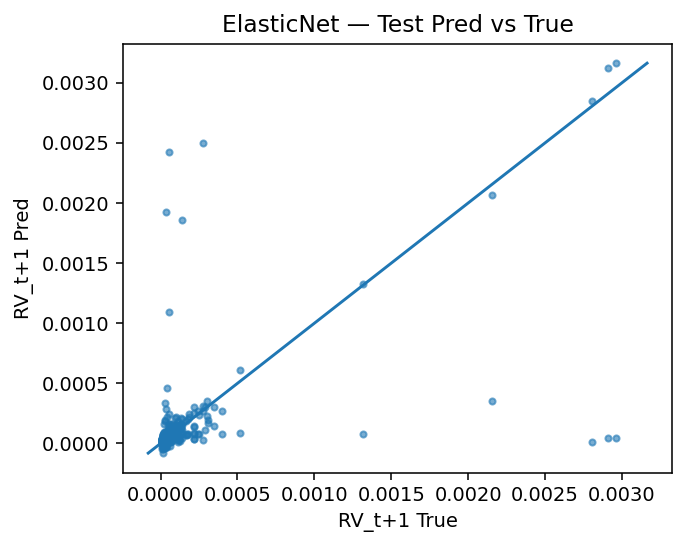

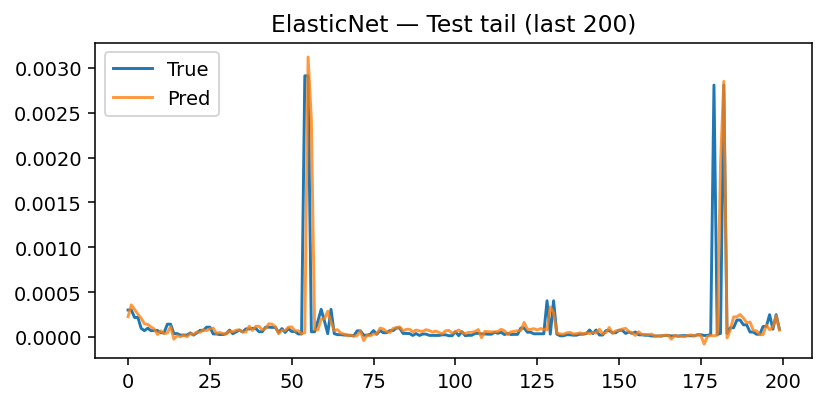


✅ Saved in /content/drive/MyDrive/Regime_pred/Models/ElasticNet_RV:
 - enet_model.joblib
 - enet_scaler.joblib
 - enet_features.json
 - enet_metrics.json
 - enet_val_predictions.csv
 - enet_test_predictions.csv
 - enet_test_scatter.png
 - enet_test_tail.png


In [12]:
import json
from joblib import dump

preds_va = pd.DataFrame({"date": dates_va, "RV_true": y_va, "RV_pred": y_va_hat,
                         "reg_true": reg_lbl_va, "reg_pred": reg_pred_va})
preds_te = pd.DataFrame({"date": dates_te, "RV_true": y_te, "RV_pred": y_te_hat,
                         "reg_true": reg_lbl_te, "reg_pred": reg_pred_te})

preds_va.to_csv(os.path.join(OUT_DIR, "enet_val_predictions.csv"), index=False)
preds_te.to_csv(os.path.join(OUT_DIR, "enet_test_predictions.csv"), index=False)

with open(os.path.join(OUT_DIR, "enet_metrics.json"), "w") as f:
    json.dump({
        "regression": {"val": m_val, "test": m_tst},
        "classification_mapped": {
            "val": {"balanced_accuracy": cls_val["balanced_accuracy"], "macro_f1": cls_val["macro_f1"]},
            "test": {"balanced_accuracy": cls_tst["balanced_accuracy"], "macro_f1": cls_tst["macro_f1"]},
        },
        "cuts": {"q_low": float(q_low), "q_high": float(q_high)}
    }, f, indent=2)

dump(enet,  os.path.join(OUT_DIR, "enet_model.joblib"))
dump(scaler, os.path.join(OUT_DIR, "enet_scaler.joblib"))
with open(os.path.join(OUT_DIR, "enet_features.json"), "w") as f:
    json.dump(feature_names, f, indent=2)

# ---- Quick diagnostic plots (saved) ----
# 1) Pred vs True (test)
plt.figure(figsize=(5,4), dpi=140)
plt.scatter(y_te, y_te_hat, s=10, alpha=0.6)
lims = [min(y_te.min(), y_te_hat.min()), max(y_te.max(), y_te_hat.max())]
plt.plot(lims, lims)
plt.xlabel("RV_t+1 True"); plt.ylabel("RV_t+1 Pred"); plt.title("ElasticNet — Test Pred vs True")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "enet_test_scatter.png")); plt.show()

# 2) Time series slice (last 200)
k = min(200, len(y_te))
plt.figure(figsize=(6,3), dpi=140)
plt.plot(range(k), y_te[-k:], label="True")
plt.plot(range(k), y_te_hat[-k:], label="Pred", alpha=0.8)
plt.legend(); plt.title("ElasticNet — Test tail (last 200)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "enet_test_tail.png")); plt.show()

print(f"\n✅ Saved in {OUT_DIR}:")
print(" - enet_model.joblib")
print(" - enet_scaler.joblib")
print(" - enet_features.json")
print(" - enet_metrics.json")
print(" - enet_val_predictions.csv")
print(" - enet_test_predictions.csv")
print(" - enet_test_scatter.png")
print(" - enet_test_tail.png")